In [11]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo

pd.set_option('display.max_row', 1200)
pd.set_option('display.max_columns', 100)

# 1955~2067년
dfDeathWoman = pd.read_excel('../../data/여성사망률추이.xlsx').set_index(['연도']).iloc[:93,:100]
dfDeathMan = pd.read_excel('../../data/남성사망률추이.xlsx').set_index(['연도']).iloc[:93,:100]
npDeathWoman = np.array(dfDeathWoman)
npDeathMan = np.array(dfDeathMan)

# 1955~2047년
dfDoctorData = pd.read_excel('../../data/doctorData.xlsx').set_index(['년도']).iloc[5:98,:]
npPassDoctor = np.around(np.array(dfDoctorData[['의대졸합격/남', '의대졸합격/여', '의전졸합격/남', '의전졸합격/여', '불합합격/남', '불합합격/여']]))
npPopulation = np.array(dfDoctorData['추계인구'])

# 2011~2016년
npDoctorAgeData = np.array(pd.read_excel('../../data/의사연령별분포.xlsx'))

In [12]:
def clusterAgeModel(rate,st,end):
    npData = np.zeros(100)
    
    for i in range(st,end):
        npData[i] = (rate**(i-end))-1  
        
    sumValue = np.sum(npData)
    npRateData = npData / sumValue
    return npRateData

def makeAlivePerson(npData,year):
    
    deathRate = np.array([npDeathMan[year], npDeathWoman[year]])
    deadPerson = np.around((npData*deathRate))
    resultData = npData - deadPerson
    
    return [resultData, deadPerson]

def makeWorkPerson(npData,tuningSet):
    valueList = np.zeros([2,100])
    c1 = tuningSet[2][0]/((tuningSet[0][0]**(100-tuningSet[1][0]))-1)
    c2 = tuningSet[2][1]/((tuningSet[0][1]**(100-tuningSet[1][1]))-1)
    for i in range(100):
        result1 = ((tuningSet[0][0]**(i-tuningSet[1][0]))-1)*c1
        result2 = ((tuningSet[0][1]**(i-tuningSet[1][1]))-1)*c2
        valueList[0][i] = 0 if result1<0 else 1 if result1>1 else  result1
        valueList[1][i] = 0 if result2<0 else 1 if result2>1 else  result2

    retirePerson = np.around(npData*valueList)
    result = npData - retirePerson
    
    return [result, retirePerson]

def makeArrayUseModel(tuningList):
    model1 = clusterAgeModel(tuningList[0][0], tuningList[1][0], tuningList[2][0]) # 의대 남
    model2 = clusterAgeModel(tuningList[0][1], tuningList[1][1], tuningList[2][1]) # 의대 여
    model3 = clusterAgeModel(tuningList[0][2], tuningList[1][2], tuningList[2][2]) # 의전원 남
    model4 = clusterAgeModel(tuningList[0][3], tuningList[1][3], tuningList[2][3]) # 의전원 여
    model5 = clusterAgeModel(tuningList[0][4], tuningList[1][4], tuningList[2][4]) # 재시험 남
    model6 = clusterAgeModel(tuningList[0][5], tuningList[1][5], tuningList[2][5]) # 재시험 여
    
    resultData =  np.array([model1, model2, model3, model4, model5, model6])
    
    return resultData

def makeNewPerson(npData, tuningSet):
    oldSize = 100
    yearSize = len(npData)
    modelSize = len(npData[0])
    
    #모델 적용 배열 93 x 6 x 100
    applyModelArray = np.zeros((yearSize,modelSize,oldSize))

    #신규인원 배열 93 x 2 x 100
    newPersonArray = np.zeros((yearSize,2,oldSize))

    
    modelAry = makeArrayUseModel(tuningSet)
    
    for i in range(yearSize):
        for j in range(modelSize):
            applyModelArray[i][j] = np.around(modelAry[j]*np.around(npData[i][j]))

            if j%2==0:
                newPersonArray[i][0] += applyModelArray[i][j]
            else:
                newPersonArray[i][1] += applyModelArray[i][j]
    
    resultData = newPersonArray
    
    return resultData

def shiftOld(personArray):
    dataArray = np.zeros((2,len(personArray[0])))
    dataArray[0] = np.roll(personArray[0], 1)  
    dataArray[1] = np.roll(personArray[1], 1)
    dataArray[0][0] = 0
    dataArray[1][0] = 0
    
    return dataArray

def makeResultPersonArray(newPersonArray, tuningSet):
    #누적인원 배열
    sizeArray = list(np.shape(newPersonArray))
    yearSize = sizeArray[0]
    
    # 93 x 2 x 100 
    resultPersonArray = np.zeros(sizeArray)
    deadPersonArray = np.zeros(sizeArray)
    retirePersonArray = np.zeros(sizeArray)

    for i in range(yearSize):
        if i>0:
            # 1살 올리기 / shiftData -> 2 x 100
            shiftData = shiftOld(resultPersonArray[i-1])
            
            # 사망률 적용 / aliveData -> 2 x 100
            aliveData = makeAlivePerson(shiftData, i)
            deadPersonArray[i] = aliveData[1]
            
            # 은퇴율 적용 / workData -> 2 x 100
            workData = makeWorkPerson(aliveData[0], tuningSet)
            retirePersonArray[i] = workData[1]
            
            # 최종 계산
            resultPersonArray[i] =  workData[0] + newPersonArray[i]
            
        else:
            resultPersonArray[i] =  newPersonArray[i]
            
            
    return [resultPersonArray,newPersonArray,deadPersonArray,retirePersonArray]


def sumPeopleUseAge(npData):
    yearSize = len(npData)
    
    resultData = np.zeros([yearSize, 3, 12])
    
    for i in range(yearSize):
        for j in range(2):
            # 남/여 소계 계산
            resultData[i][j][0] = np.sum(npData[i][j])
            resultData[i][j][1] = np.sum(npData[i][j][0:30])
            resultData[i][j][2] = np.sum(npData[i][j][30:40])
            resultData[i][j][3] = np.sum(npData[i][j][40:50])
            resultData[i][j][4] = np.sum(npData[i][j][50:60])
            resultData[i][j][5] = np.sum(npData[i][j][60:])
            
            # 남/여 비율 계산
            for n in range(6):
                resultData[i][j][6+n] = resultData[i][j][n]/resultData[i][2][0] if resultData[i][2][0] > 0 else 0
        
        for j in range(6):
            # 합계 계산
            resultData[i][2][j] = resultData[i][0][j] + resultData[i][1][j]  
            # 합계 비율 계산
            resultData[i][2][6+j] = resultData[i][2][j]/resultData[i][2][0] if resultData[i][2][0] > 0 else 0
            # 남/여 비율 계산
            resultData[i][0][6+j] = resultData[i][0][j]/resultData[i][2][0] if resultData[i][2][0] > 0 else 0
            resultData[i][1][6+j] = resultData[i][1][j]/resultData[i][2][0] if resultData[i][2][0] > 0 else 0


    return resultData

def calculateCost(npData):   
    resultData = np.zeros([6,5,5])

    for i in range(6):
        manNumCost = npData[39-i][0][1:6] - npAgeData[5-i][8:13]
        womanNumCost = npData[39-i][1][1:6] - npAgeData[5-i][14:19]
        totalNumCost = npData[39-i][2][1:6] - npAgeData[5-i][2:7]
        
        manRateCost = npData[39-i][0][7:12] - npAgeData[5-i][26:31]
        womanRateCost = npData[39-i][1][7:12] - npAgeData[5-i][32:37]
        
        npCostArray = np.array([manNumCost, womanNumCost, totalNumCost, 
                    manRateCost, womanRateCost])

        resultData[i] = npCostArray

    return resultData

def getCost(npData, tuningSet):
    newPerson = makeNewPerson(npData, tuningSet[0])
    resultPerson = makeResultPersonArray(newPerson,tuningSet[1])
    
    # sumData -> 43 x 3 x 12
    sumData = sumPeopleUseAge(resultPerson)
    costData = calculateCost(sumData)
    
    return [sumData, costData]

def makeDataFrame(npData):
    dfList = []
    for i in range(4):
        for j in range(2):
            dfResult = pd.DataFrame(npData[i][0][j]).T
            indexList = []
            indexList.append(1955)

            for k in range(1,93):
                dfResult = pd.concat([dfResult,pd.DataFrame(npData[i][k][j]).T])
                indexList.append(k+1955)

            dfResult.index = indexList 
            dfList.append(dfResult)
            
    return dfList

In [13]:
tuningSetAgeRate = [[0.9,0.7,0.3,0.3,0.9,0.7],[26,26,28,28,27,27],[39, 39, 39, 39, 39, 39]]
tuningSetRetireRate = [[1.1, 1.1],[30, 30],[0.7, 0.7]]
tuningSet = [tuningSetAgeRate, tuningSetRetireRate]

newPerson = makeNewPerson(npPassDoctor, tuningSetAgeRate)
resultData = makeResultPersonArray(newPerson,tuningSetRetireRate)

dfData = makeDataFrame(resultData)


dfResultPerson = [dfData[0],dfData[1]] # 의사수
dfNewPerson = [dfData[2],dfData[3]]    # 신규의사수
dfDeadPerson = [dfData[4],dfData[5]]   # 사망자수
dfRetirePerson = [dfData[6],dfData[7]] # 은퇴자수

In [14]:
dfNewPerson[0].iloc[50:51,26:] #신규의사수

,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
2005,382.0,372.0,320.0,273.0,231.0,193.0,159.0,129.0,101.0,76.0,54.0,35.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
exdfNewPerson0 = dfNewPerson[0].iloc[:,26:40]
exdfNewPerson0['성별']='Man'
exdfNewPerson1 = dfNewPerson[1].iloc[:,26:40]
exdfNewPerson1['성별']='Woman'
exdfNewPerson = pd.concat([exdfNewPerson0,exdfNewPerson1])
exdfNewPerson = exdfNewPerson.reset_index().rename(columns={"index": "연도"}).set_index('성별')

newPersonDict = {}

for i in range(1955,2048):
    data = exdfNewPerson[exdfNewPerson['연도']==i]
    data.drop(['연도'], axis='columns', inplace=True)
    data = data.rename_axis(None).T
    data = data.reset_index().rename(columns={'index':'age'})
    newPersonDict.setdefault(str(i), data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4167: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [54]:
newPersonDict['2018'].age

0     26
1     27
2     28
3     29
4     30
5     31
6     32
7     33
8     34
9     35
10    36
11    37
12    38
13    39
Name: age, dtype: int64

In [60]:
def makeFigure(year):
    newnew = newPersonDict[year]
    x_label = newnew.age
    trace3 = go.Bar(x=newnew.age, y=newnew.Man, name='남자',text=newnew.Man,textposition='outside')
    trace4 = go.Bar(x=newnew.age, y=newnew.Woman, name='여자',text=newnew.Woman,textposition='outside')

    data = [trace3, trace4]
    layout = go.Layout(title=year+'년 연령별 성별 신규 의사 수', )
    fig = go.Figure(data=data, layout=layout)

    #fig.update_traces(width = 0.3)
    
    fig.update_layout(
        #height=500,
        paper_bgcolor='rgb(248, 248, 255)',
        plot_bgcolor='rgb(248, 248, 255)',
        margin=dict(l=0),
        showlegend=True,
        yaxis=dict(range=[0,800])
      
    )
    return fig

makeFigure('2002').show()

In [58]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([

    dcc.Graph(id='indicator-graphic'),

    dcc.Slider(
        id='year--slider',
        min=1976,
        max=2021,
        value=2018,
        marks={i: '{}'.format(i) for i in range(1976,2022)},
        step=1
    )
])

@app.callback(
    Output('indicator-graphic', 'figure'),
    [Input('year--slider', 'value')])
def update_graph(year_value):
    return makeFigure(str(year_value))


if __name__ == '__main__':
    app.run_server(
        port=50000,
        host='0.0.0.0'
    )

Dash is running on http://0.0.0.0:50000/

Dash is running on http://0.0.0.0:50000/

Dash is running on http://0.0.0.0:50000/

Dash is running on http://0.0.0.0:50000/

Dash is running on http://0.0.0.0:50000/

Dash is running on http://0.0.0.0:50000/

Dash is running on http://0.0.0.0:50000/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:50000/ (Press CTRL+C to quit)
163.152.233.20 - - [07/Nov/2020 07:43:17] "GET / HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:17] "GET /_dash-layout HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:17] "GET /_dash-dependencies HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:17] "GET /_favicon.ico?v=1.17.0 HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:17] "POST /_dash-update-component HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:25] "POST /_dash-update-component HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:25] "POST /_dash-update-component HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:26] "POST /_dash-update-component HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:26] "POST /_dash-update-component HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:27] "POST /_dash-update-component HTTP/1.1" 200 -
163.152.233.20 - - [07/Nov/2020 07:43:27] "POST /_dash-update-component HTTP/1.1" 200 -
163.152.233.20

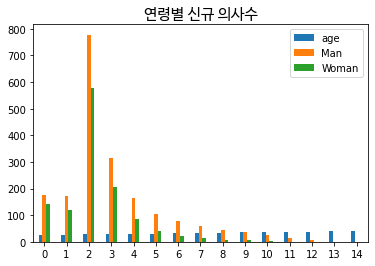

In [9]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

font_path = '../../data/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=font_path, size=15)


ax = newPersonDict['2018'].plot(kind='bar', rot=0)
plt.title('연령별 신규 의사수', fontproperties=fontprop)
plt.show()